# Basic feature interrelation analysis using the 'fip3' library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fip import profiles

In [19]:
DATASET_NAME = 'ChEMBL28'
FEATURES_NAME = 'ECFP1-like substructures'
COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_coomx.csv'
COOCCURRENCE_MX_VECTOR_COUNT = 2066376
MINIMAL_COOCCURRENCE_CUTOFF = 10

## Loading interrelation profiles
From interrelation files already preprocessed by scripts in fip3/scripts

In [3]:
p = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
p

In [4]:
p.df

value
feature1         feature2               
C=O              C=O             1424230
                 Cc(c)c           624876
                 c-n(c)n           37580
                 c=O              120205
                 cC               273990
...                                  ...
[N+][N-]S        cn(C)n                2
[N-][N+](=O)[O-] c=N                   2
c=N              cS([N-])(=O)=O        2
CCI              NS(=O)(=O)O          13
NS(=O)(=O)O      cc(n)Br               9

[193434 rows x 1 columns]

## General characterization of co-occurrence profile

In [5]:
print(f"There are {len(p.distinct_features())} distinct {FEATURES_NAME} within {DATASET_NAME}.")

There are 2711 distinct ECFP1-like substructures within ChEMBL28.


In [6]:
self_relations_values = p.select_self_relations()['value']
self_relations_values

feature1             feature2           
C=O                  C=O                    1424230
Cc(c)c               Cc(c)c                  717878
c-n(c)n              c-n(c)n                  55340
c=O                  c=O                     222434
cC                   cC                      408262
                                             ...   
cS(=C)N              cS(=C)N                      2
[N+]C=O              [N+]C=O                      2
CO[TeH]              CO[TeH]                      2
Cl[TeH]              Cl[TeH]                      2
O[TeH](O)(Cl)(Cl)Cl  O[TeH](O)(Cl)(Cl)Cl          2
Name: value, Length: 2711, dtype: int64

[Text(0.5, 1.0, 'Stand-alone ECFP1-like substructures occurrence in ChEMBL28'),
 Text(0.5, 0, 'Stand-alone occurrence count within ChEMBL28'),
 Text(0, 0.5, 'ECFP1-like substructures')]

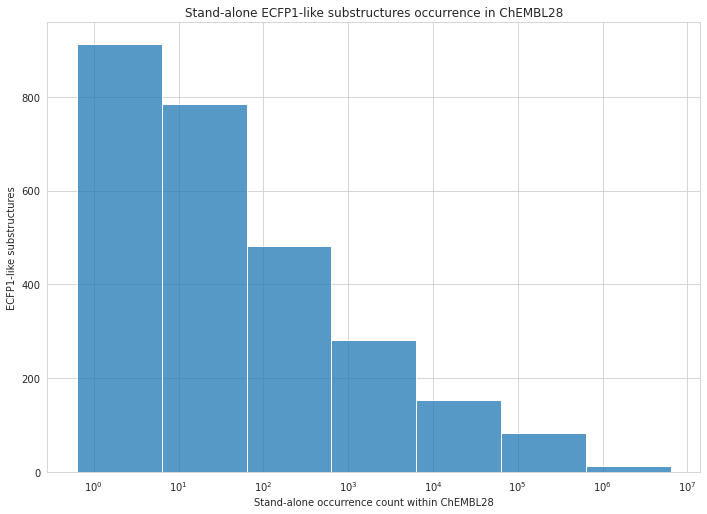

In [7]:
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(self_relations_values, log_scale=True, discrete=True)
ax.set(title=f"Stand-alone {FEATURES_NAME} occurrence in {DATASET_NAME}",
        xlabel=f"Stand-alone occurrence count within {DATASET_NAME}", ylabel=f"{FEATURES_NAME}")

In [8]:
cooccurrence_values = p.select_raw_interrelations()['value']
cooccurrence_values

feature1          feature2      
C=O               Cc(c)c            624876
                  c-n(c)n            37580
                  c=O               120205
                  cC                273990
                  cC(c)=O            30748
                                     ...  
[N+][N-]S         cn(C)n                 2
[N-][N+](=O)[O-]  c=N                    2
c=N               cS([N-])(=O)=O         2
CCI               NS(=O)(=O)O           13
NS(=O)(=O)O       cc(n)Br                9
Name: value, Length: 190723, dtype: int64

In [9]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{cooccurrence_values.sum()} feature co-occurrences for {FEATURES_NAME} within {DATASET_NAME}")

There is in total 33719310 feature stand-alone occurrences and 279452441 feature co-occurrences for ECFP1-like substructures within ChEMBL28


[Text(0.5, 1.0, 'Co-occurrence counts of ECFP1-like substructures in ChEMBL28'),
 Text(0.5, 0, 'Co-occurrence counts within ChEMBL28'),
 Text(0, 0.5, 'ECFP1-like substructures co-occurrences')]

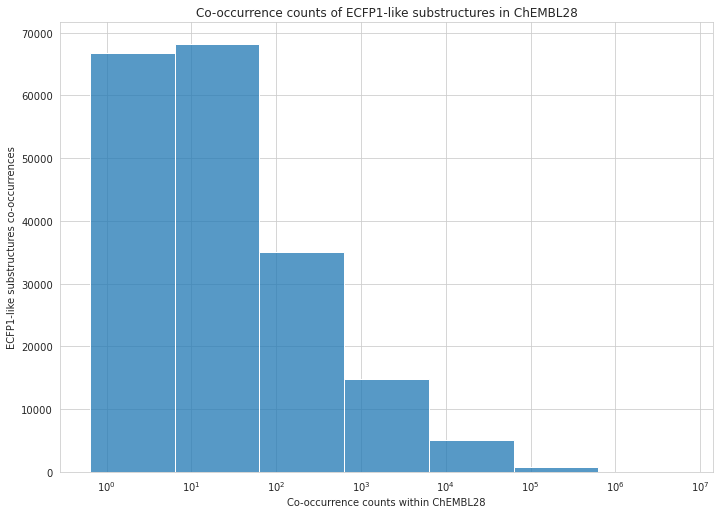

In [10]:
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(cooccurrence_values, log_scale=True, discrete=True)
ax.set(title=f"Co-occurrence counts of {FEATURES_NAME} in {DATASET_NAME}",
        xlabel=f"Co-occurrence counts within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} co-occurrences")

In [11]:
print(f"The maximum theoretical number of different feature interrelations of the observed {FEATURES_NAME} \
within {DATASET_NAME} would be {int(p.num_max_interrelations())}, whereas the number of actual observed \
interrelations is only {p.num_raw_interrelations()}. Therefore, the interrelation matrix population ratio is \
approx. {p.num_raw_interrelations() / p.num_max_interrelations():.4f}.")

The maximum theoretical number of different feature interrelations of the observed ECFP1-like substructures within ChEMBL28 would be 3673405, whereas the number of actual observed interrelations is only 190723. Therefore, the interrelation matrix population ratio is approx. 0.0519.


In [12]:
print(f"The mean co-occurrence value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean co-occurrence value for ECFP1-like substructures within ChEMBL28 is 1465.23, with the standard deviation of 15074.57. The mean stand-alone value is 12437.96, with the standard deviation of 82150.28.


## General characterization of pointwise mutual information profile

In [13]:
p = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(
    profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
        p, vector_count=COOCCURRENCE_MX_VECTOR_COUNT))
p

In [14]:
p.df

value
feature1         feature2                
C=O              C=O             0.000000
                 Cc(c)c          0.336752
                 c-n(c)n        -0.021437
                 c=O            -0.350960
                 cC             -0.038451
...                                   ...
[N+][N-]S        cn(C)n          0.865606
[N-][N+](=O)[O-] c=N             5.737005
c=N              cS([N-])(=O)=O  2.396381
CCI              NS(=O)(=O)O     3.943011
NS(=O)(=O)O      cc(n)Br         1.848521

[193434 rows x 1 columns]

In [15]:
pmi_values = p.select_raw_interrelations()['value']
pmi_values

feature1          feature2      
C=O               Cc(c)c            0.336752
                  c-n(c)n          -0.021437
                  c=O              -0.350960
                  cC               -0.038451
                  cC(c)=O           0.536921
                                      ...   
[N+][N-]S         cn(C)n            0.865606
[N-][N+](=O)[O-]  c=N               5.737005
c=N               cS([N-])(=O)=O    2.396381
CCI               NS(=O)(=O)O       3.943011
NS(=O)(=O)O       cc(n)Br           1.848521
Name: value, Length: 190723, dtype: float64

[Text(0.5, 1.0, 'PMI value distribution for ECFP1-like substructures in ChEMBL28'),
 Text(0.5, 0, 'PMI value bins within ChEMBL28'),
 Text(0, 0.5, 'ECFP1-like substructures counts')]

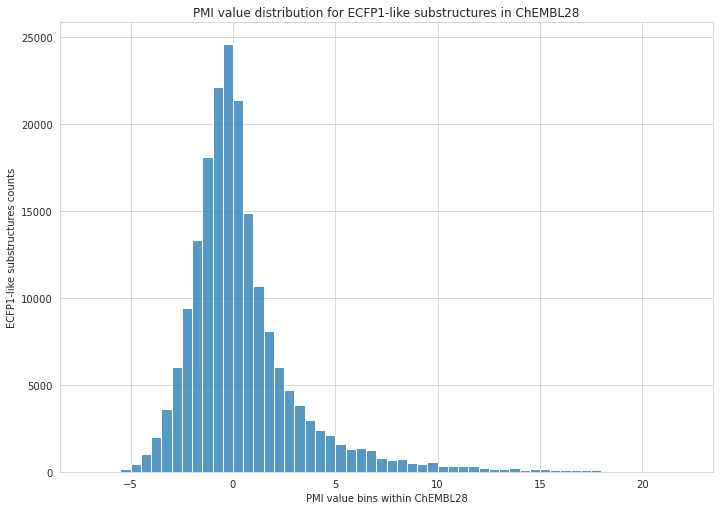

In [16]:
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(pmi_values, binwidth=0.5, binrange=(-7, 22))
ax.set(title=f"PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}",
        xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")

In [17]:
print(f"The mean PMI value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean PMI value for ECFP1-like substructures within ChEMBL28 is 0.47, with the standard deviation of 2.90. The mean stand-alone value is 0.00, with the standard deviation of 0.00.


In [18]:
major_pmi_values = p.select_major_interrelations()['value']
major_pmi_values

KeyboardInterrupt: 

In [ ]:
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(major_pmi_values, binwidth=0.5, binrange=(-7, 22))
ax.set(title=f"Major PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}",
        xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")